<a href="https://colab.research.google.com/github/Sandeep-4469/ML_Project/blob/main/The_Matrix_OG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p /content/datasets
!wget -O /content/datasets/datasets.zip 'https://www.dropbox.com/scl/fo/pi9enz9ebq88u11bslzde/AEgFjW1vFsTtarLZVyFCV94?rlkey=fz9t33e4wzumesicz7o3t3680&st=16un1fgu&dl=1'
!unzip /content/datasets/datasets.zip -d /content/datasets
!rm /content/datasets/datasets.zip
!wget -O data.csv https://www.dropbox.com/scl/fi/o7233oyy5ztnrq3kmolrj/DOM_hourly.csv?rlkey=8ax4e5ojld8ir5ivq9m8h9ag1&st=25jsg22t&dl=1

--2024-10-19 05:46:50--  https://www.dropbox.com/scl/fo/pi9enz9ebq88u11bslzde/AEgFjW1vFsTtarLZVyFCV94?rlkey=fz9t33e4wzumesicz7o3t3680&st=16un1fgu&dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6020:18::a27d:4012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf6c7162e7d1c40c7977241b7a8.dl.dropboxusercontent.com/zip_download_get/CAHVPlxmNjUQ2SNaZqX5W1BtGdGM6198c4VUUJT2wMFNZQHc0uVwXscVEpIMsBs45Pbxx_Wo5iH19uLfr4p2ozZVF4WE35AhEoumB4Mpet6vyw# [following]
--2024-10-19 05:46:50--  https://ucf6c7162e7d1c40c7977241b7a8.dl.dropboxusercontent.com/zip_download_get/CAHVPlxmNjUQ2SNaZqX5W1BtGdGM6198c4VUUJT2wMFNZQHc0uVwXscVEpIMsBs45Pbxx_Wo5iH19uLfr4p2ozZVF4WE35AhEoumB4Mpet6vyw
Resolving ucf6c7162e7d1c40c7977241b7a8.dl.dropboxusercontent.com (ucf6c7162e7d1c40c7977241b7a8.dl.dropboxusercontent.com)... 162.125.65.15, 2620:100:6021:15::a27d:410f
Connecting to ucf6c7162e7d1c40

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller

from pandas.plotting import autocorrelation_plot
from pandas.tseries.offsets import DateOffset

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense, Dropout
from keras import models, layers
import tensorflow as tf

import xgboost as xgb

import os

import seaborn as sns

In [3]:
folder_path = '/content/datasets'
files = os.listdir(folder_path)
files.sort()
files

['Yearly Demand Profile_17_24.xlsx',
 'Yearly Demand Profile_19-18.xlsx',
 'Yearly Demand Profile_21-20.xlsx',
 'Yearly Demand Profile_22-23.xlsx']

In [4]:
dataframes = []
for file in files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_excel(file_path)
    dataframes.append(df)

merged_df = pd.concat(dataframes, ignore_index=True)

merged_df.head()

,Year,Date,Hourly Demand Met (in MW)
0,2017,01-Jan 12am,108985.17
1,2017,01-Jan 1am,105856.08
2,2017,01-Jan 2am,103115.75
3,2017,01-Jan 3am,102407.04
4,2017,01-Jan 4am,104235.34


In [5]:
data = merged_df.copy()

#EDA

##Null values

In [6]:
data.isnull().sum()

,0
Year,4
Date,16
Hourly Demand Met (in MW),16


In [7]:
data.dropna(inplace=True)

In [8]:
data.shape

(64248, 3)

In [9]:
data

,Year,Date,Hourly Demand Met (in MW)
0,2017,01-Jan 12am,108985.17
1,2017,01-Jan 1am,105856.08
2,2017,01-Jan 2am,103115.75
3,2017,01-Jan 3am,102407.04
4,2017,01-Jan 4am,104235.34
...,...,...,...
64255,2022,31-Dec 7pm,175551.59
64256,2022,31-Dec 8pm,165990.79
64257,2022,31-Dec 9pm,157032.51
64258,2022,31-Dec 10pm,149875.96


#Data Preprocessing

In [10]:
data['Datetime'] = pd.to_datetime(data['Year'].astype(str) + ' ' + data['Date'], format='%Y %d-%b %I%p')

data['day_of_year'] = data['Datetime'].dt.dayofyear
data['day_of_month'] = data['Datetime'].dt.day
data['day_of_week'] = data['Datetime'].dt.dayofweek  # 0 = Monday, 6 = Sunday
data['hour'] = data['Datetime'].dt.hour
data['month'] = data['Datetime'].dt.month
data['year'] = data['Datetime'].dt.year

data = data[['Datetime','day_of_year', 'day_of_month', 'day_of_week', 'hour', 'month', 'year', 'Hourly Demand Met (in MW)']]
data.rename(columns={'Hourly Demand Met (in MW)': 'energy'}, inplace=True)
data

<ipython-input-10-62ac1a30e0da>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={'Hourly Demand Met (in MW)': 'energy'}, inplace=True)


,Datetime,day_of_year,day_of_month,day_of_week,hour,month,year,energy
0,2017-01-01 00:00:00,1,1,6,0,1,2017,108985.17
1,2017-01-01 01:00:00,1,1,6,1,1,2017,105856.08
2,2017-01-01 02:00:00,1,1,6,2,1,2017,103115.75
3,2017-01-01 03:00:00,1,1,6,3,1,2017,102407.04
4,2017-01-01 04:00:00,1,1,6,4,1,2017,104235.34
...,...,...,...,...,...,...,...,...
64255,2022-12-31 19:00:00,365,31,5,19,12,2022,175551.59
64256,2022-12-31 20:00:00,365,31,5,20,12,2022,165990.79
64257,2022-12-31 21:00:00,365,31,5,21,12,2022,157032.51
64258,2022-12-31 22:00:00,365,31,5,22,12,2022,149875.96


In [42]:
data_sorted = data.sort_values(by='Datetime')
sorted_check = data_sorted['Datetime'].is_monotonic_increasing

if sorted_check:
    print("The Datetime column is now sorted in ascending order.")
else:
    print("The Datetime column is still not sorted.")

The Datetime column is now sorted in ascending order.


#Data Visualisation (-----)

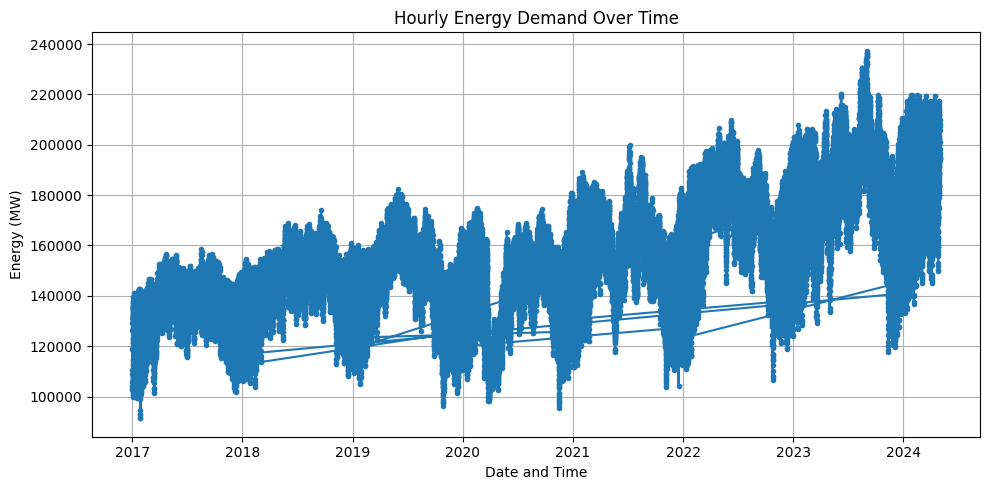

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(data['Datetime'], data['energy'],marker='.')
plt.title('Hourly Energy Demand Over Time')
plt.xlabel('Date and Time')
plt.ylabel('Energy (MW)')
plt.grid()
plt.tight_layout()
plt.show()


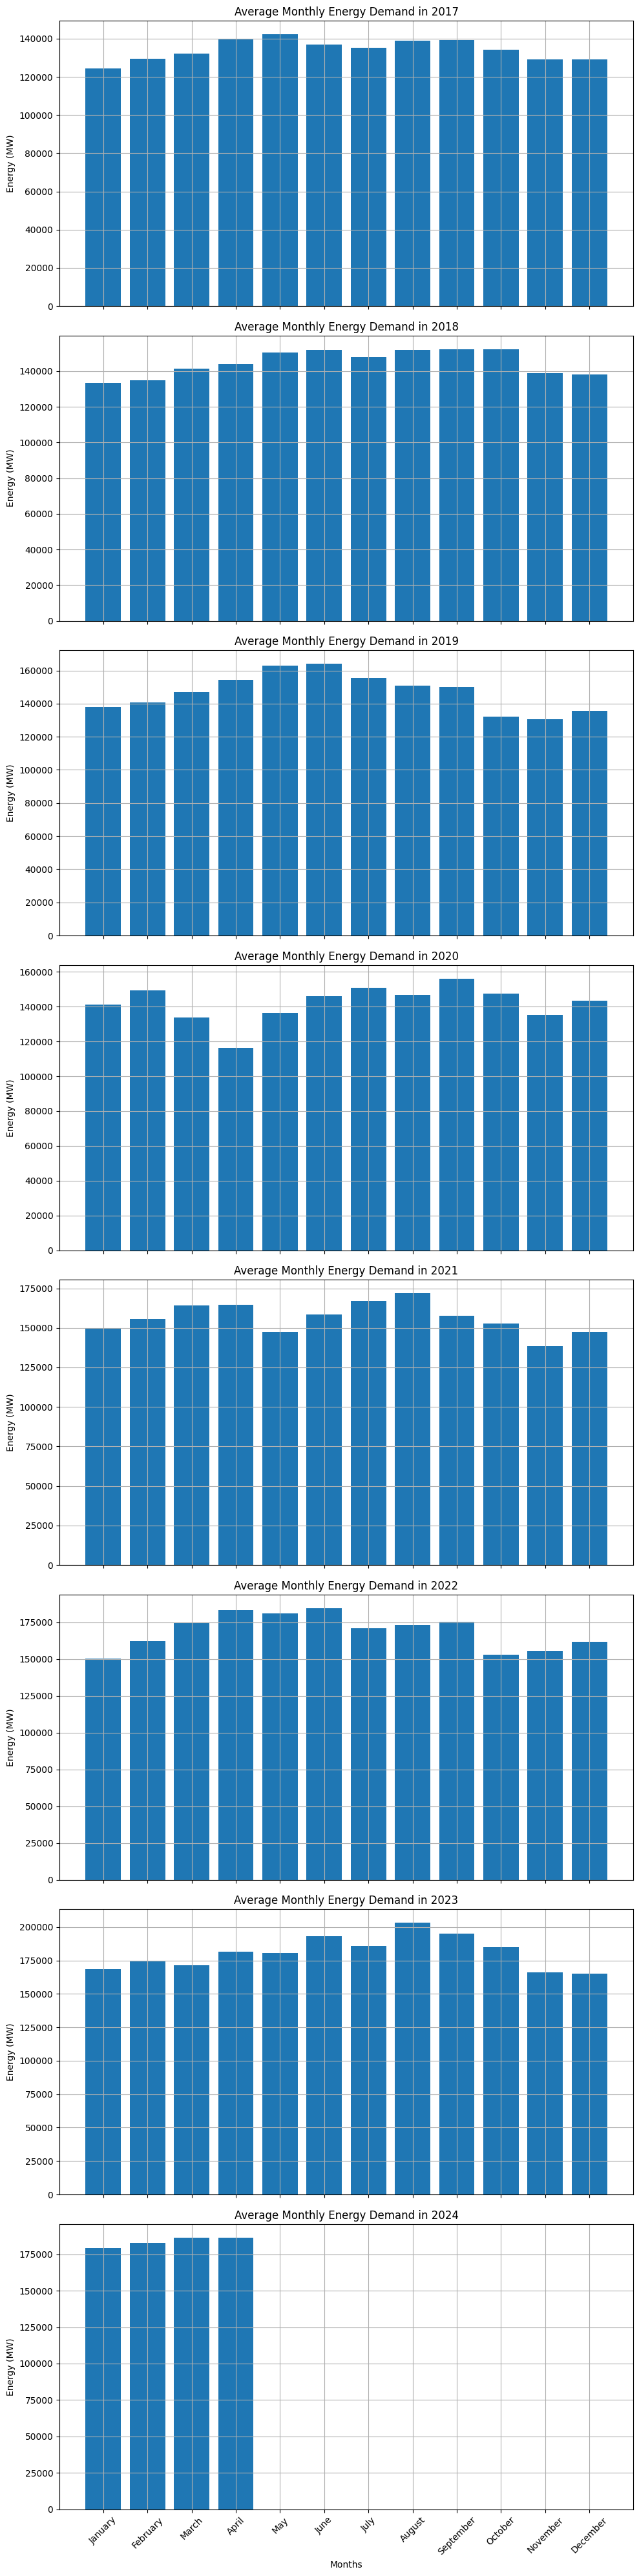

In [12]:
unique_years = list(data['year'].unique())
unique_years.sort()
num_years = len(unique_years)

fig, axes = plt.subplots(num_years, 1, figsize=(10, 5 * num_years), sharex=True)

for ax, year in zip(axes, unique_years):
    year_data = data[data['year'] == year].copy()
    year_data.loc[:, 'Month'] = year_data['Datetime'].dt.month_name()

    monthly_data = year_data.groupby('Month')['energy'].mean().reindex(['January', 'February', 'March', 'April', 'May',
                                                                         'June', 'July', 'August', 'September',
                                                                         'October', 'November', 'December'])

    ax.bar(monthly_data.index, monthly_data.values)
    ax.set_title(f'Average Monthly Energy Demand in {year}')
    ax.set_ylabel('Energy (MW)')
    ax.grid()

plt.xlabel('Months')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

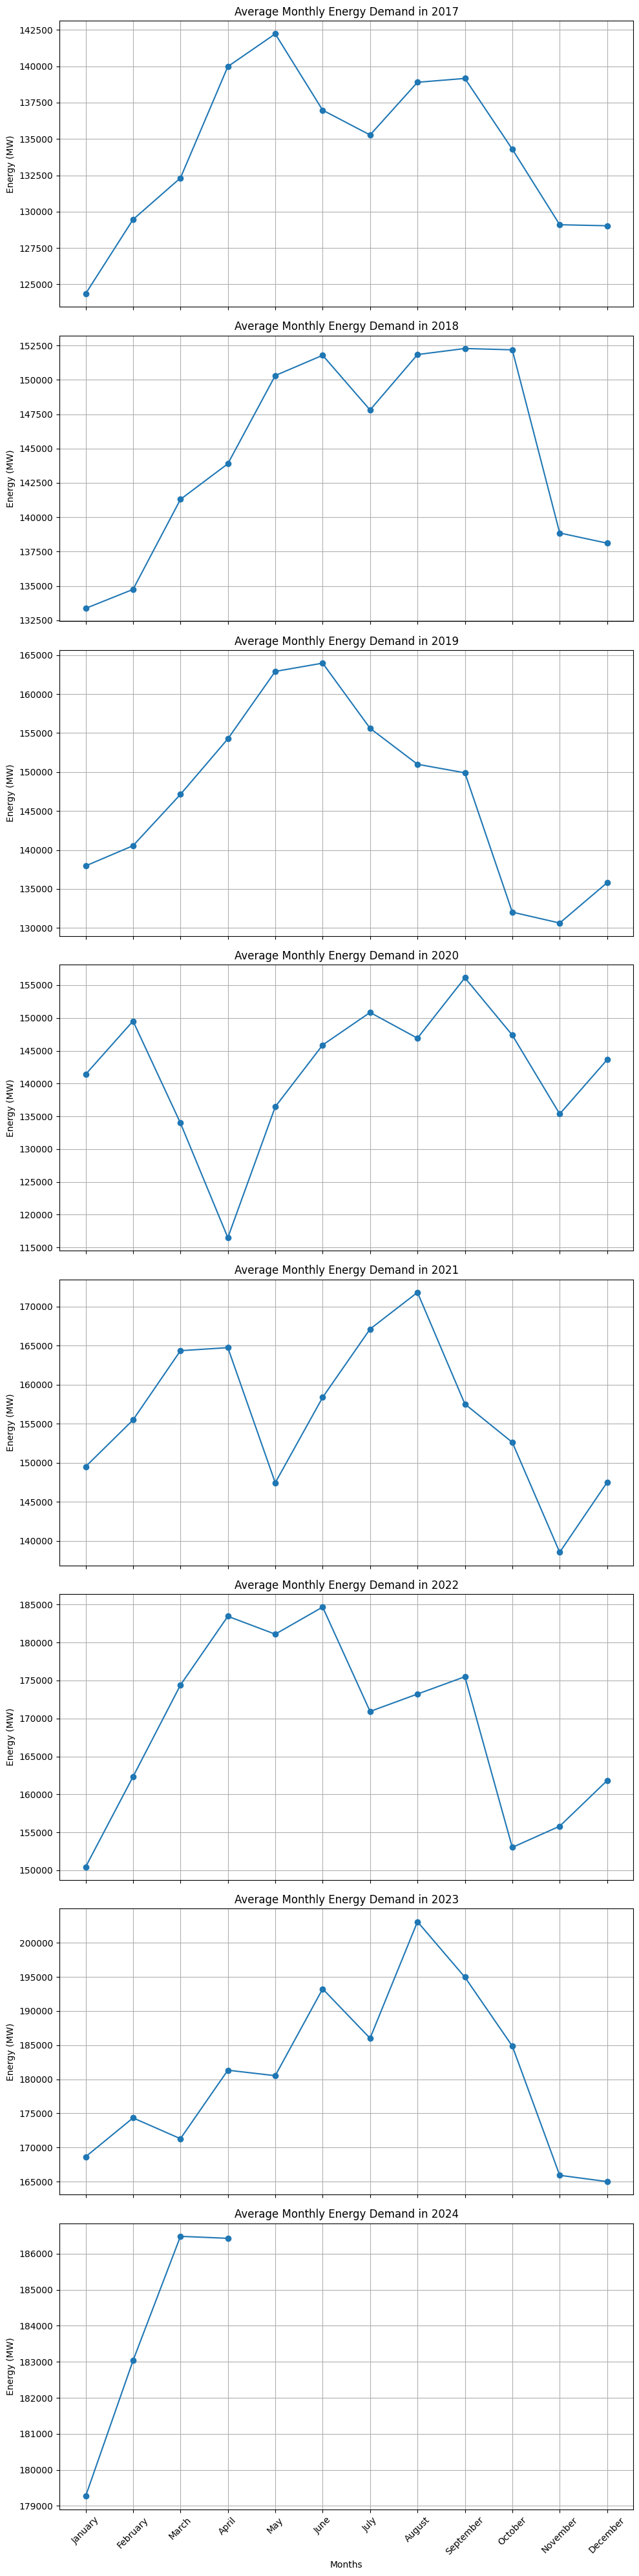

In [13]:
fig, axes = plt.subplots(num_years, 1, figsize=(10, 5 * num_years), sharex=True)

for ax, year in zip(axes, unique_years):
    year_data = data[data['year'] == year].copy()
    year_data.loc[:, 'Month'] = year_data['Datetime'].dt.month_name()

    monthly_data = year_data.groupby('Month')['energy'].mean().reindex(['January', 'February', 'March', 'April', 'May',
                                                                         'June', 'July', 'August', 'September',
                                                                         'October', 'November', 'December'])

    ax.plot(monthly_data.index, monthly_data.values, marker='o')
    ax.set_title(f'Average Monthly Energy Demand in {year}')
    ax.set_ylabel('Energy (MW)')
    ax.grid()

plt.xlabel('Months')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

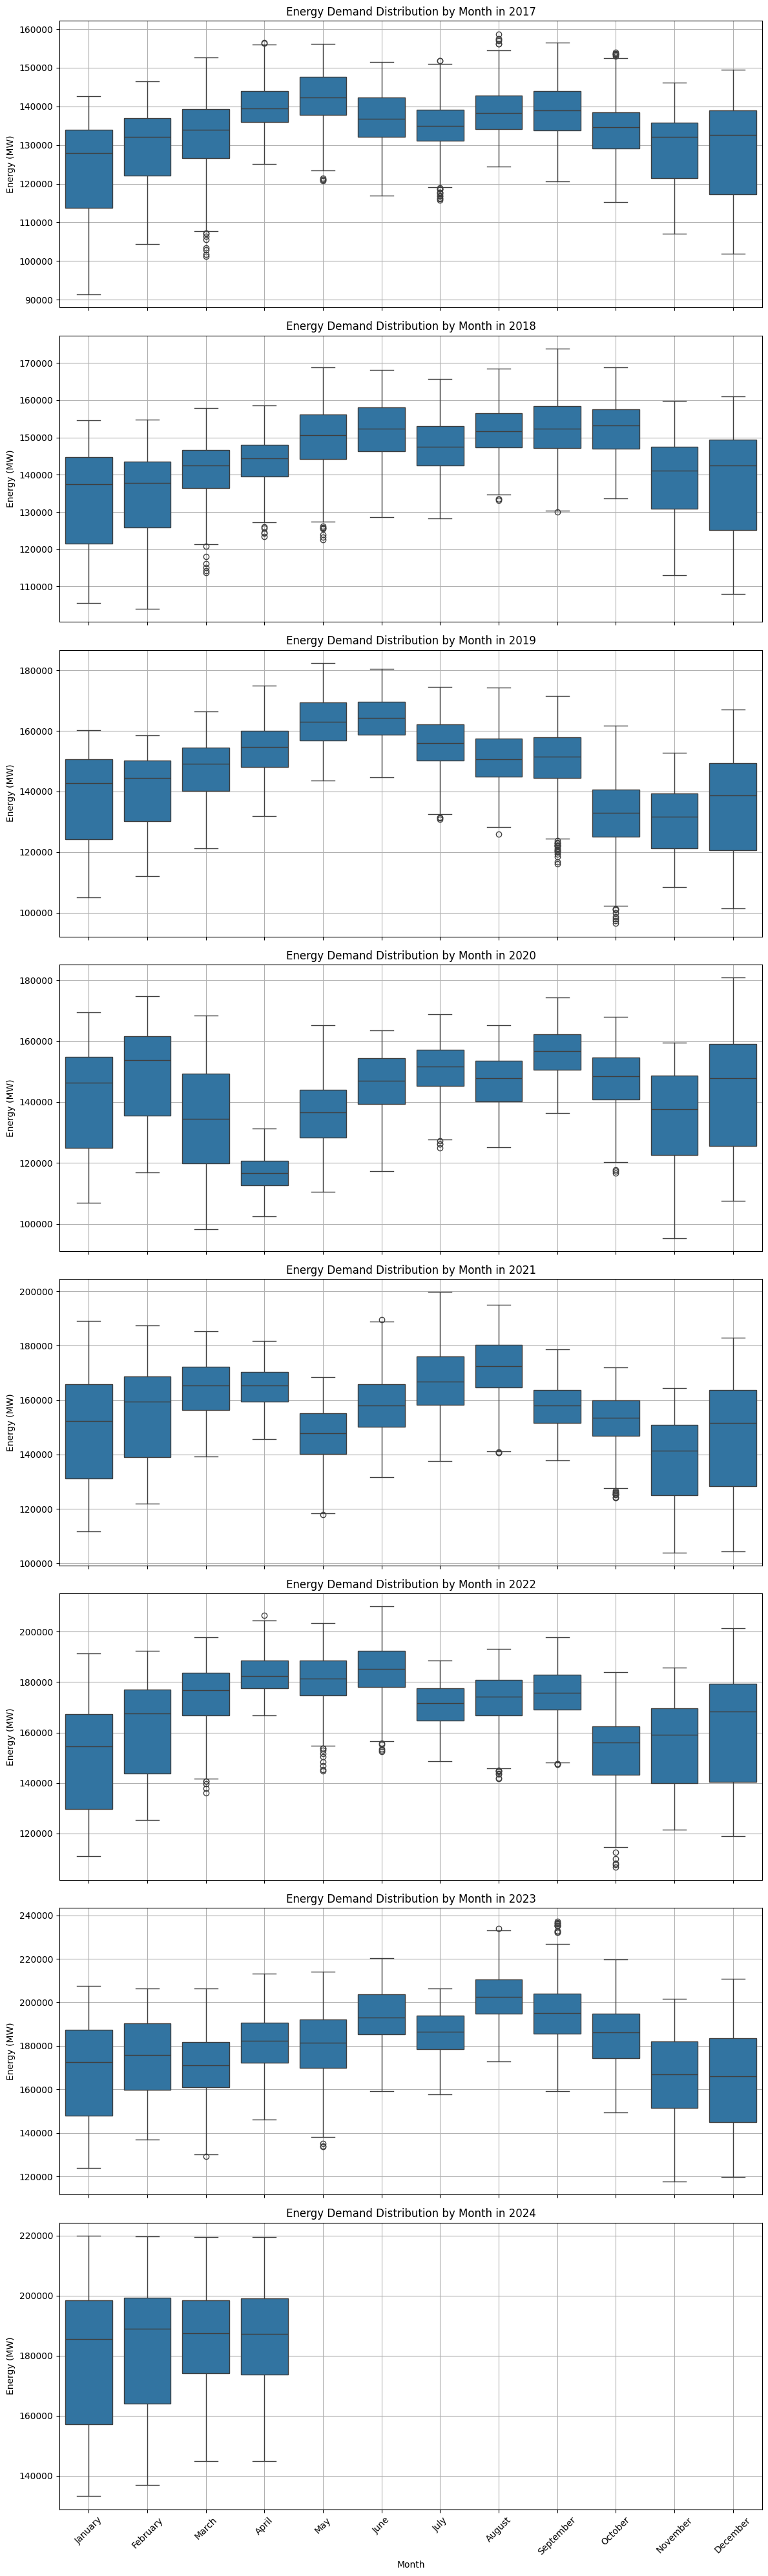

In [14]:
fig, axes = plt.subplots(num_years, 1, figsize=(12, 5 * num_years), sharex=True)

for ax, year in zip(axes, unique_years):
    year_data = data[data['year'] == year].copy()
    year_data.loc[:, 'Month'] = year_data['Datetime'].dt.month_name()

    sns.boxplot(x='Month', y='energy', data=year_data, order=['January', 'February', 'March', 'April', 'May',
                                                               'June', 'July', 'August', 'September',
                                                               'October', 'November', 'December'], ax=ax)
    ax.set_title(f'Energy Demand Distribution by Month in {year}')
    ax.set_ylabel('Energy (MW)')
    ax.grid()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


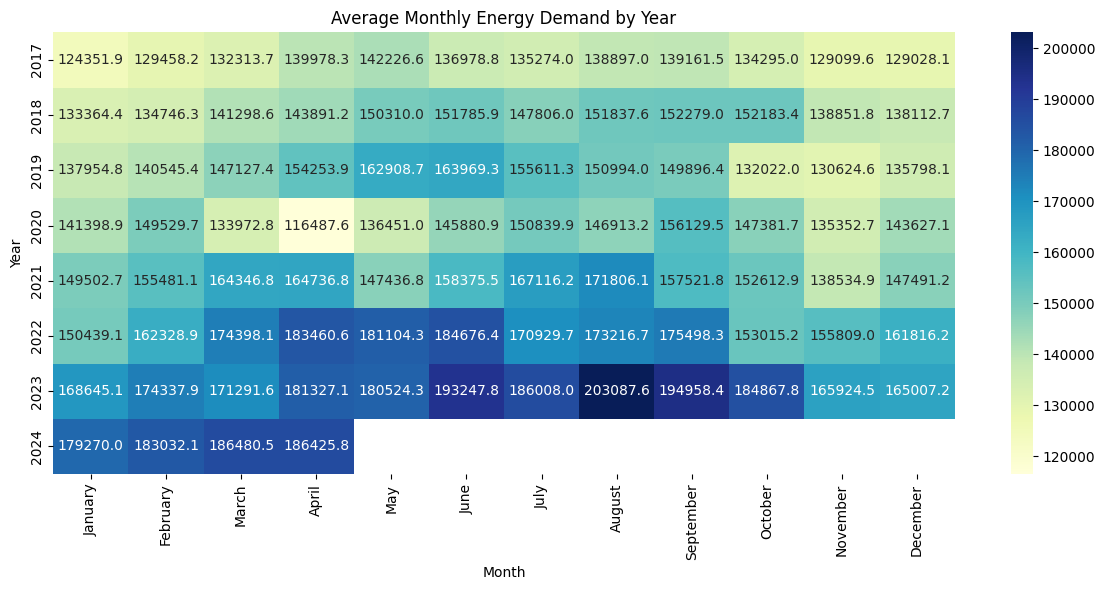

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

heatmap_data = data.copy()
heatmap_data['Month'] = heatmap_data['Datetime'].dt.month_name()

heatmap_summary = heatmap_data.groupby(['year', 'Month'])['energy'].mean().unstack().reindex(
    index=sorted(data['year'].unique()),
    columns=['January', 'February', 'March', 'April', 'May',
             'June', 'July', 'August', 'September',
             'October', 'November', 'December']
)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_summary, annot=True, fmt=".1f", cmap='YlGnBu')
plt.title('Average Monthly Energy Demand by Year')
plt.xlabel('Month')
plt.ylabel('Year')
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

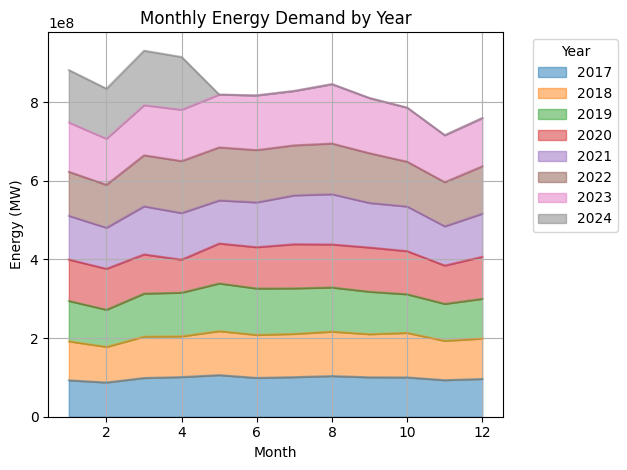

In [16]:
monthly_data = data.groupby(['year', 'month'])['energy'].sum().unstack()

plt.figure(figsize=(12, 6))
monthly_data.T.plot(kind='area', alpha=0.5)
plt.title('Monthly Energy Demand by Year')
plt.xlabel('Month')
plt.ylabel('Energy (MW)')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

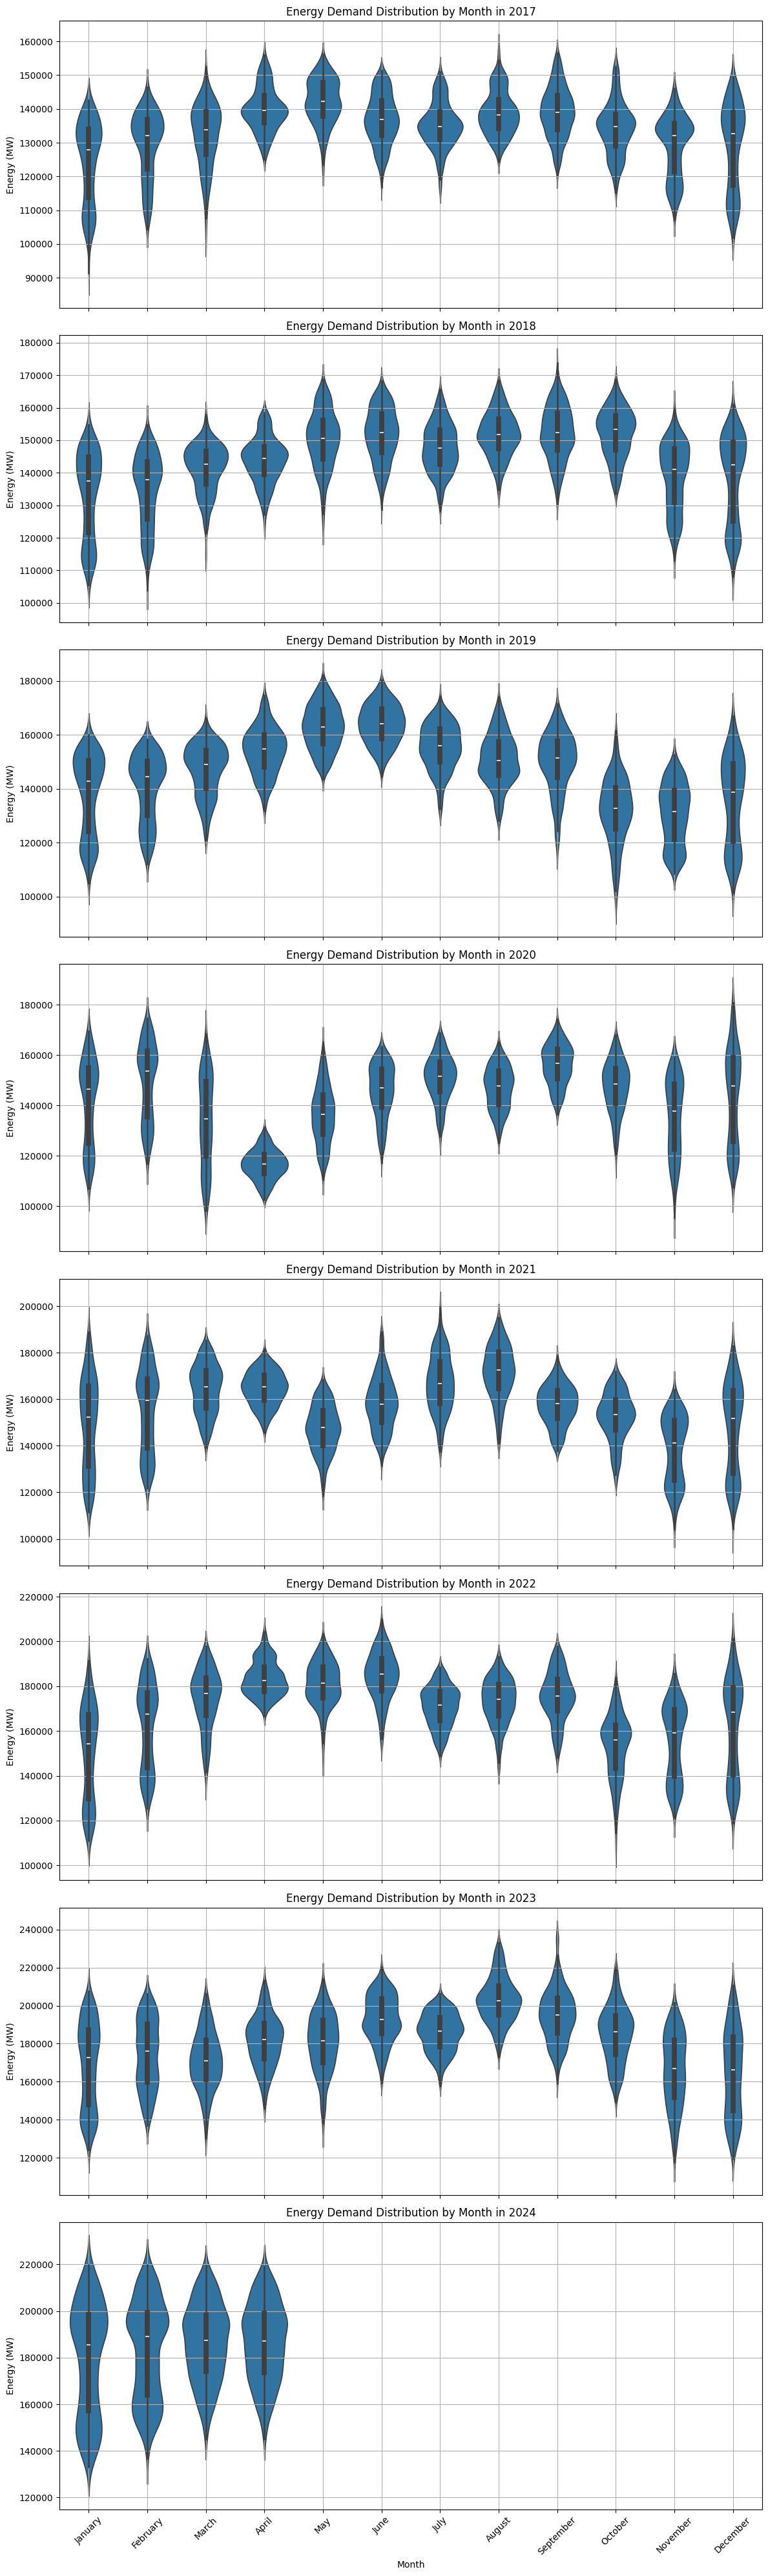

In [17]:
fig, axes = plt.subplots(num_years, 1, figsize=(12, 5 * num_years), sharex=True)

for ax, year in zip(axes, unique_years):
    year_data = data[data['year'] == year].copy()
    year_data.loc[:, 'Month'] = year_data['Datetime'].dt.month_name()

    sns.violinplot(x='Month', y='energy', data=year_data,
                   order=['January', 'February', 'March', 'April', 'May',
                          'June', 'July', 'August', 'September',
                          'October', 'November', 'December'], ax=ax)

    ax.set_title(f'Energy Demand Distribution by Month in {year}')
    ax.set_ylabel('Energy (MW)')
    ax.grid()

plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Insights for Each Graph

## 1. Bar Graph: Average Monthly Energy Demand (2017-2024)

- **2017-2019**:
  - Relatively stable energy demand across months.
  - Slight peaks observed during summer months (June-August).
- **2020**:
  - Lower demand in early months, possibly due to the pandemic.
  - Recovery in the second half of the year.
- **2021-2023**:
  - Higher average demand compared to earlier years.
  - Significant peaks during summer months (June-August).


## 2. Box Plot: Energy Demand Distribution by Month (2017-2024)

- **2017-2019**:
  - Moderate variation in energy demand.
  - Fewer outliers and more consistent distribution.
- **2020**:
  - Large variation in demand, especially in early months due to the pandemic.
- **2021-2023**:
  - Increased variability, particularly in summer months.
  - Higher number of outliers suggests unusual demand patterns.
- **2023**:
  - Outliers suggest significant spikes in energy demand during summer (July-August).

## 3. Heatmap: Average Monthly Energy Demand by Year (2017-2024)

- **Color gradient**:
  - Lighter colors in earlier years (2017-2019) indicate lower demand.
  - Darker colors in 2021-2024 reflect rising energy consumption.
- **Seasonal patterns**:
  - Summer months (June-August) show peaks in demand across all years.
- **2023-2024**:
  - These years show significantly higher energy usage, especially in early 2024.

## 4. Violin Plot

1. **2017**:
   - Stable distribution throughout the year.
   - Slight peaks in May and July.

2. **2018**:
   - Noticeable increase in demand from April to August.
   - Higher variability in summer months.

3. **2019**:
   - Higher demand in April, May, and July.
   - Lower demand in November and December.

4. **2020**:
   - Sharp drop in April (possibly due to COVID-19).
   - Demand recovers by year-end.

5. **2021**:
   - Consistent increase from January to June.
   - Drop in August, recovery in December.

6. **2022**:
   - Fluctuations, especially in April and May.
   - Higher variance in the latter months.

7. **2023**:
   - High energy demand in July and August.
   - Stable but high variance across the year.

8. **2024**:
   - General increase in demand compared to earlier years.
   - July and August show the highest peaks.



#Stationary Test

In [18]:
def adfuller_test(energy):
    result=adfuller(energy)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Data has no unit root and is stationary")
        return 0
    else:
        print("Time series has a unit root, indicating it is non-stationary ")
        return 1
p = adfuller_test(data['energy'])

ADF Test Statistic : -5.406958682108405
p-value : 3.2750573334244405e-06
#Lags Used : 61
Number of Observations Used : 64186
Data has no unit root and is stationary


In [19]:
def is_stationary(series):
    adf_result = adfuller(series)
    return adf_result[1] <= 0.05

def make_stationary(series):
    differenced_data = series.copy()
    num_differences = 0

    while not is_stationary(differenced_data):
        differenced_data = differenced_data.diff().dropna()
        num_differences += 1
        print(f"Applied differencing: {num_differences}")

    return differenced_data

In [20]:
if p==1:
  df_stat = make_stationary(data['DOM_MW'])

else:
  df_stat = data.copy()

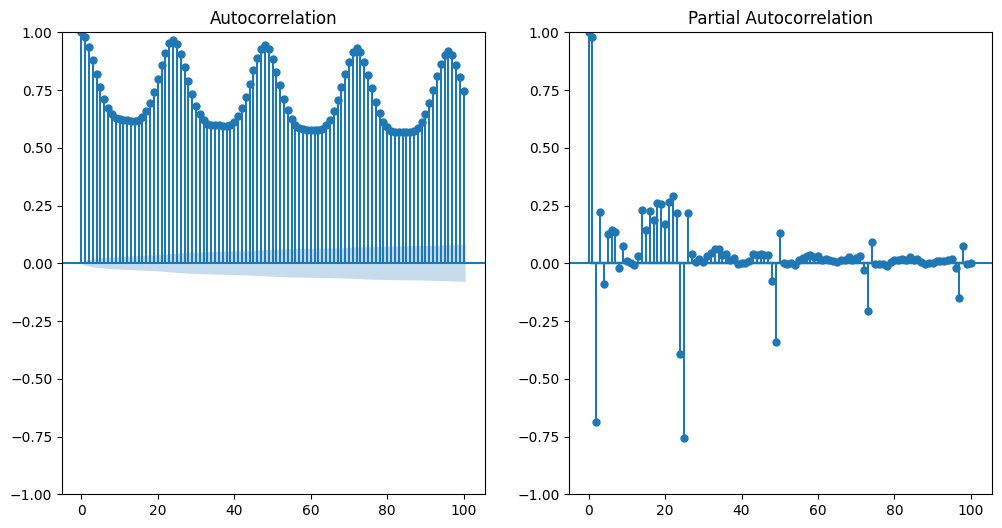

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sm.graphics.tsa.plot_acf(data['energy'], lags=100, ax=ax[0])
sm.graphics.tsa.plot_pacf(data['energy'], lags=100, ax=ax[1])
plt.show()

#Data Proprocessing

##MinMax Scaling

In [22]:
target_scaler = MinMaxScaler()
target = data['energy'].values
target_scaled = target_scaler.fit_transform(target.reshape(-1,1))

##Making Sequential Data

In [23]:
def create_sequences(X, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps])
        ys.append(X[i + time_steps])
    return np.array(Xs), np.array(ys)

In [24]:
TIME_STEPS = 20
X_seq, y_seq = create_sequences(target_scaled, TIME_STEPS)

In [25]:
split_index = int(len(X_seq) * 0.8)
X_train_seq, X_test_seq = X_seq[:split_index], X_seq[split_index:]
y_train_seq, y_test_seq = y_seq[:split_index], y_seq[split_index:]

#Models

##RNN

In [29]:
rnn_model = Sequential()
rnn_model.add(SimpleRNN(40, activation='tanh', return_sequences=True, input_shape=(TIME_STEPS, X_train_seq.shape[2])))
rnn_model.add(Dropout(0.2))
rnn_model.add(SimpleRNN(40, activation='tanh', return_sequences=True))
rnn_model.add(Dropout(0.2))
rnn_model.add(SimpleRNN(40, activation='tanh'))
rnn_model.add(Dropout(0.2))
rnn_model.add(Dense(1))

rnn_model.compile(optimizer='adam', loss='mean_squared_error')
rnn_model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, verbose=1)
rnn_predictions = rnn_model.predict(X_test_seq)
y_pred_rnn_flat = rnn_predictions.flatten()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0724
Epoch 2/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.0025
Epoch 3/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.0012
Epoch 4/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 8.5670e-04
Epoch 5/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 7.5065e-04
Epoch 6/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 6.9786e-04
Epoch 7/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 6.6279e-04
Epoch 8/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 6.3324e-04
Epoch 9/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 6.6724e-04
Epoch 10/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 6.2007e-04
402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


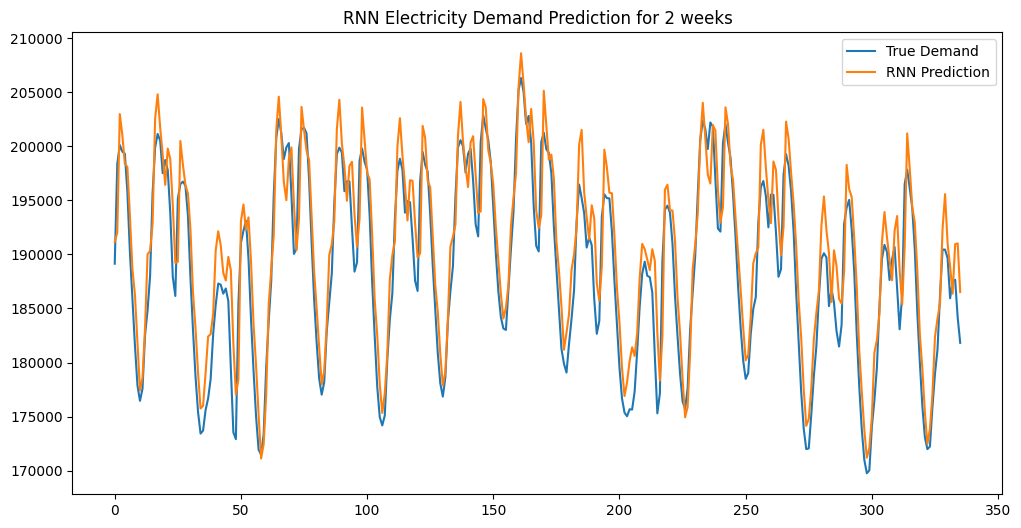

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(target_scaler.inverse_transform(y_test_seq)[:24*14], label='True Demand')
plt.plot(target_scaler.inverse_transform(y_pred_rnn_flat.reshape(-1,1))[:24*14], label='RNN Prediction')
plt.title('RNN Electricity Demand Prediction for 2 weeks')
plt.legend()
plt.show()

##LSTM (simple)

In [31]:
lstm_model = Sequential()
lstm_model.add(LSTM(60, activation='tanh', return_sequences=True, input_shape=(X_train_seq.shape[1], 1)))
lstm_model.add(Dropout(0.15))
lstm_model.add(LSTM(40, activation='tanh', return_sequences=True))
lstm_model.add(Dropout(0.15))
lstm_model.add(LSTM(40, activation='tanh'))
lstm_model.add(Dropout(0.15))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, verbose=1)
lstm_predictions = lstm_model.predict(X_test_seq)
y_pred_lstm_flat = lstm_predictions.flatten()

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1606/1606 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 0.0111
Epoch 2/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 0.0015
Epoch 3/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 8.5114e-04
Epoch 4/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 6.4442e-04
Epoch 5/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 5.5939e-04
Epoch 6/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 5.4376e-04
Epoch 7/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 5.0806e-04
Epoch 8/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 4.8758e-04
Epoch 9/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 4.9044e-04
Epoch 10/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 4.7683e-04
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


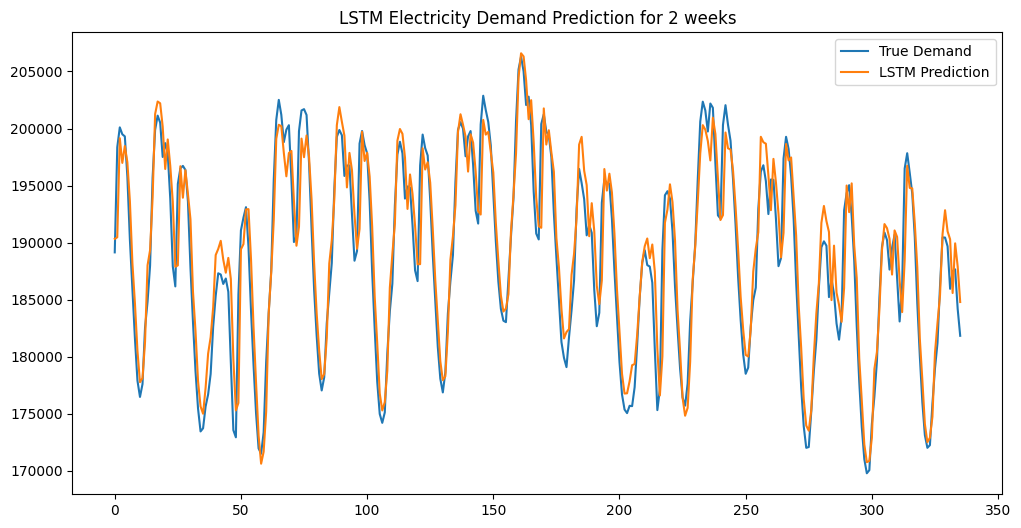

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(target_scaler.inverse_transform(y_test_seq)[:24*14], label='True Demand')
plt.plot(target_scaler.inverse_transform(y_pred_lstm_flat.reshape(-1,1))[:24*14], label='LSTM Prediction')
plt.title('LSTM Electricity Demand Prediction for 2 weeks')
plt.legend()
plt.show()

##Bidirectional LSTM

In [33]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional

bilstm_model = Sequential()
bilstm_model.add(Bidirectional(LSTM(60, activation='tanh', return_sequences=True), input_shape=(X_train_seq.shape[1], 1)))
bilstm_model.add(Dropout(0.15))
bilstm_model.add(Bidirectional(LSTM(40, activation='tanh', return_sequences=True)))
bilstm_model.add(Dropout(0.15))
bilstm_model.add(Bidirectional(LSTM(40, activation='tanh')))
bilstm_model.add(Dropout(0.15))
bilstm_model.add(Dense(1))

bilstm_model.compile(optimizer='adam', loss='mean_squared_error')

bilstm_model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, verbose=1)

bilstm_predictions = bilstm_model.predict(X_test_seq)
y_pred_bilstm_flat = bilstm_predictions.flatten()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - loss: 0.0072
Epoch 2/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 0.0011
Epoch 3/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - loss: 8.4147e-04
Epoch 4/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - loss: 6.6141e-04
Epoch 5/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 6.0201e-04
Epoch 6/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - loss: 5.4200e-04
Epoch 7/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 4.7926e-04
Epoch 8/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - loss: 4.1363e-04
Epoch 9/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 3.8213e-04
Epoch 10/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - loss: 3.6289e-04
402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


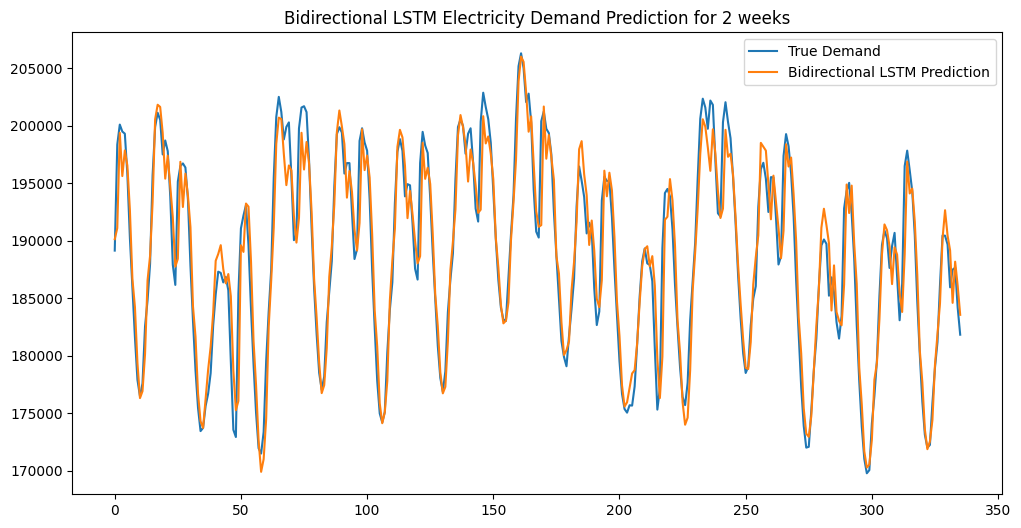

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(target_scaler.inverse_transform(y_test_seq)[:24*14], label='True Demand')
plt.plot(target_scaler.inverse_transform(y_pred_bilstm_flat.reshape(-1,1))[:24*14], label='Bidirectional LSTM Prediction')
plt.title('Bidirectional LSTM Electricity Demand Prediction for 2 weeks')
plt.legend()
plt.show()

##GRU

In [35]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout

gru_model = Sequential()
gru_model.add(GRU(60, activation='tanh', return_sequences=True, input_shape=(X_train_seq.shape[1], 1)))
gru_model.add(Dropout(0.15))
gru_model.add(GRU(40, activation='tanh', return_sequences=True))
gru_model.add(Dropout(0.15))
gru_model.add(GRU(40, activation='tanh'))
gru_model.add(Dropout(0.15))
gru_model.add(Dense(1))

gru_model.compile(optimizer='adam', loss='mean_squared_error')

gru_model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, verbose=1)

gru_predictions = gru_model.predict(X_test_seq)
y_pred_gru_flat = gru_predictions.flatten()


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1606/1606 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 0.0060
Epoch 2/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.0010
Epoch 3/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 7.6484e-04
Epoch 4/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 6.6720e-04
Epoch 5/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 5.8455e-04
Epoch 6/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 5.3208e-04
Epoch 7/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 4.7500e-04
Epoch 8/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 4.9691e-04
Epoch 9/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 4.6708e-04
Epoch 10/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 4.4231e-04
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


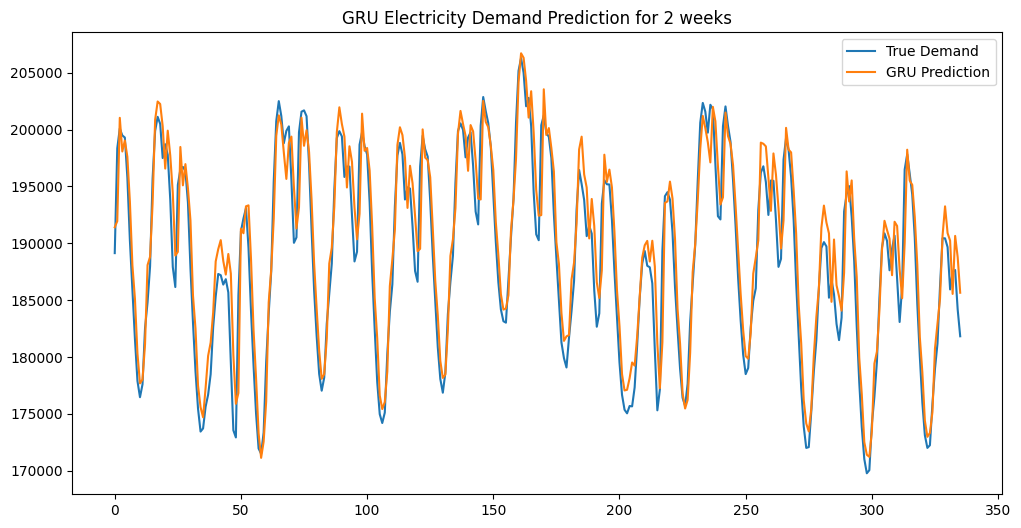

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(target_scaler.inverse_transform(y_test_seq)[:24*14], label='True Demand')
plt.plot(target_scaler.inverse_transform(y_pred_gru_flat.reshape(-1,1))[:24*14], label='GRU Prediction')
plt.title('GRU Electricity Demand Prediction for 2 weeks')
plt.legend()
plt.show()

##Facebook Prophet

In [37]:
pip install prophet

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_mtmwrkb/udtqeqbv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_mtmwrkb/p_a4chv4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73157', 'data', 'file=/tmp/tmp_mtmwrkb/udtqeqbv.json', 'init=/tmp/tmp_mtmwrkb/p_a4chv4.json', 'output', 'file=/tmp/tmp_mtmwrkb/prophet_modelq0kfrz24/prophet_model-20241019061240.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:12:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:13:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


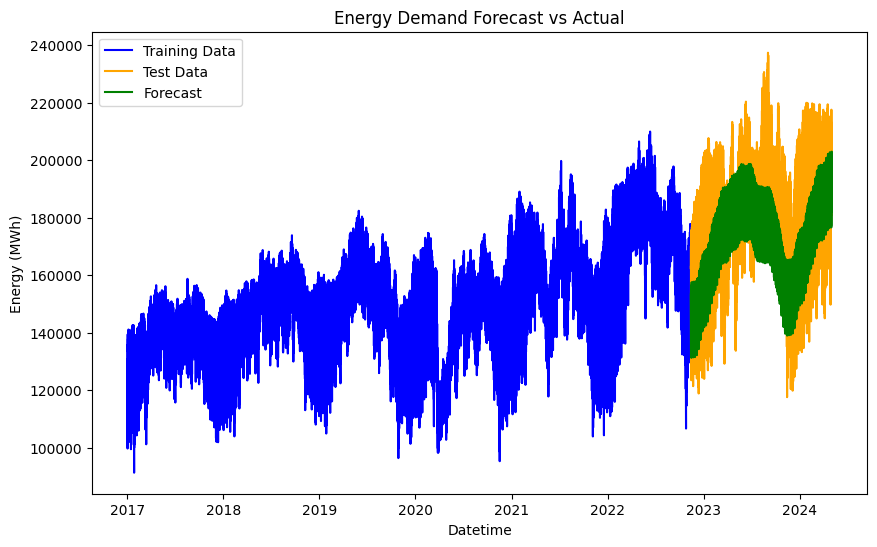

In [43]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

train_size = int(len(data) * 0.8)
train, test = data_sorted.iloc[:train_size], data_sorted.iloc[train_size:]

prophet_data = train[['Datetime', 'energy']].rename(columns={'Datetime': 'ds', 'energy': 'y'})

model = Prophet()
model.fit(prophet_data)

test_periods = len(test)
future = model.make_future_dataframe(periods=test_periods, freq='H')

forecast = model.predict(future)
forecast_test = forecast[-test_periods:]

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(train['Datetime'], train['energy'], color='blue')
ax.plot(test['Datetime'], test['energy'], color='orange')
ax.plot(forecast_test['ds'], forecast_test['yhat'], color='green')

ax.set_xlabel('Datetime')
ax.set_ylabel('Energy (MWh)')
ax.set_title('Energy Demand Forecast vs Actual')

ax.legend(['Training Data', 'Test Data', 'Forecast'])

plt.show()


##LSTM with attention

In [44]:
from keras.models import Model
from keras.layers import LSTM, Dropout, Dense, Input, Attention, Concatenate, Reshape

input_shape = (X_train_seq.shape[1], 1)

inputs = Input(shape=input_shape)

lstm_out1 = LSTM(60, activation='tanh', return_sequences=True)(inputs)
dropout1 = Dropout(0.15)(lstm_out1)

lstm_out2 = LSTM(60, activation='tanh', return_sequences=True)(dropout1)
dropout2 = Dropout(0.15)(lstm_out2)

attention = Attention()([dropout1, dropout2])
merged = Concatenate()([dropout2, attention])

lstm_out3 = LSTM(40, activation='tanh')(merged)
dropout3 = Dropout(0.15)(lstm_out3)

output = Dense(1)(dropout3)

lstm_att = Model(inputs, output)

lstm_att.compile(optimizer='adam', loss='mean_squared_error')

lstm_att.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, verbose=1)

att_predictions = lstm_att.predict(X_test_seq)
y_pred_att_flat = lstm_predictions.flatten()


Epoch 1/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 0.0094
Epoch 2/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.0013
Epoch 3/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 7.5384e-04
Epoch 4/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 5.9381e-04
Epoch 5/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 5.3667e-04
Epoch 6/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 5.1060e-04
Epoch 7/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 4.9710e-04
Epoch 8/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 4.7796e-04
Epoch 9/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 4.6810e-04
Epoch 10/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 4.4313e-04
Epoch 11/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 4.2664e-04
Epoch 12/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 4.1433e-04
Epoch 13/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 4.2087e-04
Epoch 14/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━

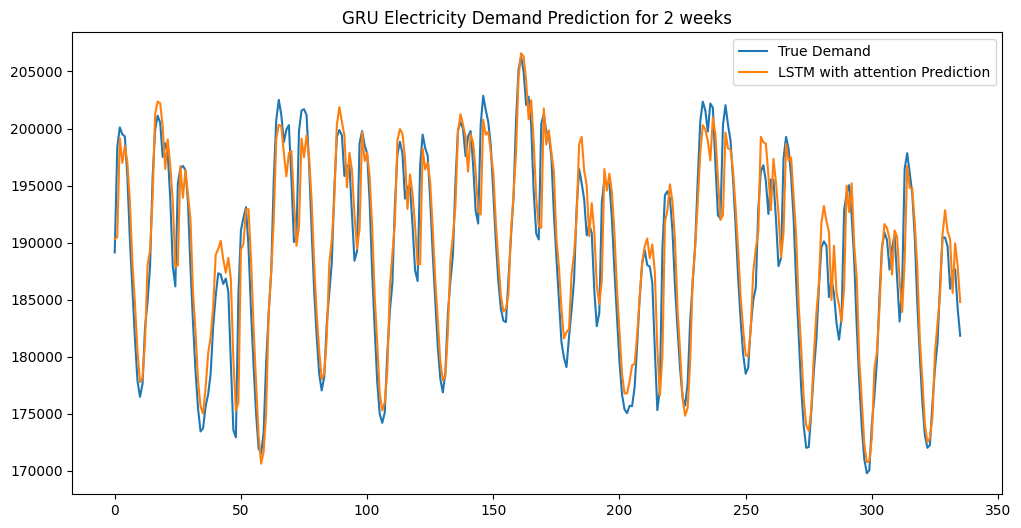

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(target_scaler.inverse_transform(y_test_seq)[:24*14], label='True Demand')
plt.plot(target_scaler.inverse_transform(y_pred_att_flat.reshape(-1,1))[:24*14], label='LSTM with attention Prediction')
plt.title('GRU Electricity Demand Prediction for 2 weeks')
plt.legend()
plt.show()

#Metrics

In [49]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
metrics = {
    'Model': ['LSTM', 'RNN','GRU', 'Bidirectional LSTM','LSTM with Attention','Prophet'],
    'Mean Absolute Error (MAE)': [
        mean_absolute_error(y_test_seq, y_pred_lstm_flat),
        mean_absolute_error(y_test_seq, y_pred_rnn_flat),
        mean_absolute_error(y_test_seq, y_pred_gru_flat),
        mean_absolute_error(y_test_seq, y_pred_bilstm_flat),
        mean_absolute_error(y_test_seq, y_pred_att_flat),
        mean_absolute_error(test['energy'].values, forecast[-test_periods:]['yhat'].values)
    ],
    'Mean Squared Error (MSE)': [
        mean_squared_error(y_test_seq, y_pred_lstm_flat),
        mean_squared_error(y_test_seq, y_pred_rnn_flat),
        mean_squared_error(y_test_seq, y_pred_gru_flat),
        mean_squared_error(y_test_seq, y_pred_bilstm_flat),
        mean_squared_error(y_test_seq, y_pred_att_flat),
        mean_squared_error(test['energy'].values, forecast[-test_periods:]['yhat'].values)
    ],
    'R-squared (R²)': [
        r2_score(y_test_seq, y_pred_lstm_flat),
        r2_score(y_test_seq, y_pred_rnn_flat),
        r2_score(y_test_seq, y_pred_gru_flat),
        r2_score(y_test_seq, y_pred_bilstm_flat),
        r2_score(y_test_seq, y_pred_att_flat),
        r2_score(test['energy'].values, forecast[-test_periods:]['yhat'].values)
    ]
}

evaluation_metrics = pd.DataFrame(metrics)
evaluation_metrics

,Model,Mean Absolute Error (MAE),Mean Squared Error (MSE),R-squared (R²)
0,LSTM,0.013268,3.091293e-04,0.984512
1,RNN,0.018934,5.398728e-04,0.972952
2,GRU,0.014094,3.327492e-04,0.983329
3,Bidirectional LSTM,0.012758,2.880645e-04,0.985568
4,LSTM with Attention,0.013268,3.091293e-04,0.984512
5,Prophet,13397.866767,2.589673e+08,0.411005
